In [31]:
import os
import ee
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt

ee.Initialize()

In [32]:
shp = gp.read_file("../shape/cv.shp")

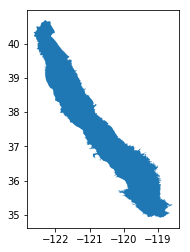

In [33]:
shp.plot()

In [34]:
lls = shp.simplify(0.0009).geometry.iloc[0]

In [35]:
x,y = lls.exterior.coords.xy

In [36]:
coords = [list(zip(x,y))]

In [37]:
area = ee.Geometry.Polygon(coords)

In [191]:
nlcd11 = ee.Image("USGS/NLCD/NLCD2011")
nlcd01 = ee.Image("USGS/NLCD/NLCD2001")
nlcd06 = ee.Image("USGS/NLCD/NLCD2006")
cdl = ee.Image("USDA/NASS/CDL/2016")


In [194]:
def img_to_arr(eeImage, var_name):
    temp = eeImage.select(var_name).clip(area)
    latlon = eeImage.pixelLonLat().addBands(temp)
    
    latlon = latlon.reduceRegion(
        reducer = ee.Reducer.toList(),
        geometry = area, 
        scale = 1000
        )
    
    data = np.array((ee.Array(latlon.get(var_name)).getInfo()))
    lats = np.array((ee.Array(latlon.get('latitude')).getInfo()))
    lons = np.array((ee.Array(latlon.get('longitude')).getInfo()))
    
    lc,freq = np.unique(data,return_counts = True)
    
    return data, lats,lons 

def imc_to_arr(eeImage):
    temp = eeImage.filterBounds(area).first().pixelLonLat()
    
    latlon = temp.reduceRegion(
        reducer = ee.Reducer.toList(),
        geometry = area, 
        scale = 1000
        )
    
    data = np.array((ee.Array(latlon.get('cropland')).getInfo()))
    lats = np.array((ee.Array(latlon.get('latitude')).getInfo()))
    lons = np.array((ee.Array(latlon.get('longitude')).getInfo()))
    
    lc,freq = np.unique(data,return_counts = True)
    
    return data, lats,lons 

def arr_to_img(data,lats,lons):
    uniquelats = np.unique(lats)
    uniquelons = np.unique(lons)
    
    ncols = len(uniquelons)
    nrows = len(uniquelats)
    
    ys = uniquelats[1] - uniquelats[0]
    xs = uniquelons[1] - uniquelons[0]
    
    arr = np.zeros([nrows, ncols], np.float32)
    
    counter = 0
    for y in range(0, len(arr),1):
        for x in range(0, len(arr[0]),1):
            if lats[counter] == uniquelats[y] and lons[counter] == uniquelons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniquelats)-1-y,x] = data[counter]
                
    return arr

In [220]:
# CDL
data, lats, lons = img_to_arr(cdl, 'cropland')

# NLCD11
# data, lats, lons = img_to_arr(nlcd01, 'landcover')

In [221]:
img = arr_to_img(data,lats,lons)

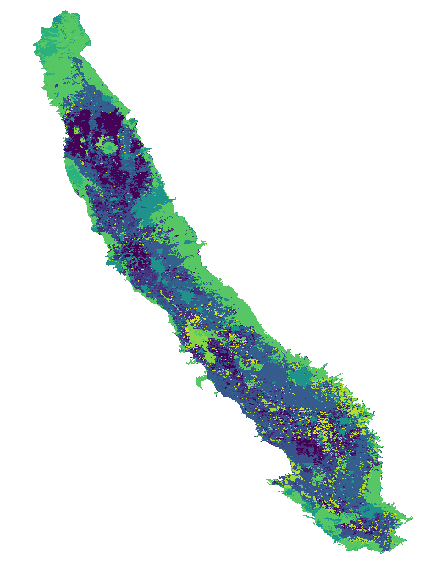

In [222]:
img[img == 0] = np.nan
plt.figure(figsize=(15,10))
plt.axis("off")
plt.imshow(img)
plt.show()

<img src="https://i.stack.imgur.com/7sOWc.jpg" width="200" height="200" />


In [223]:
vals, counts = np.unique(img,return_counts = True)

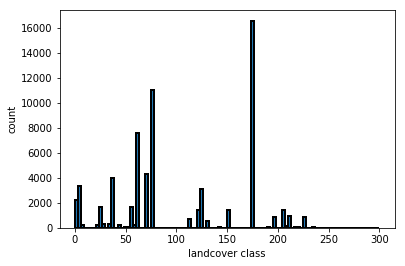

In [228]:
plt.hist(img.ravel(),100,[0,300],  lw=2, edgecolor = 'black'); 
plt.ylabel("count")
plt.xlabel('landcover class')
plt.show()

In [229]:
vals, counts

(array([ 1.,  2.,  3., ..., nan, nan, nan], dtype=float32),
 array([ 876, 1314, 3303, ...,    1,    1,    1]))

In [230]:
vals[~np.isnan(vals)]

array([  1.,   2.,   3.,   4.,   6.,  12.,  13.,  21.,  22.,  23.,  24.,
        27.,  28.,  31.,  33.,  36.,  37.,  41.,  42.,  43.,  44.,  46.,
        48.,  49.,  50.,  53.,  54.,  57.,  58.,  59.,  61.,  66.,  67.,
        68.,  69.,  71.,  72.,  74.,  75.,  76.,  77., 111., 121., 122.,
       123., 124., 131., 141., 142., 152., 176., 190., 195., 204., 205.,
       206., 208., 209., 211., 212., 213., 214., 216., 217., 218., 220.,
       222., 224., 225., 226., 227., 229., 236., 237., 238.],
      dtype=float32)

In [227]:
Crop_id	Description
1	Water
2	Urban
3	Native classes
4	Orchards, groves, and vineyards
5	Pasture/Hay
6	Row Crops
7	Small Grains
8	Idle/fallow
9	Truck, nursery, and berry crops
10	Citrus and subtropical
11	Field crops
12	Vineyards
13	Pasture
14	Grain and hay crops
15	Semiagricultural (livestock feedlots, diaries, poultry farms)
16	Deciduous fruits and nuts
17	Rice
18	Cotton
19	Developed
20	Cropland and pasture
21	Cropland
22	Irrigated Row and Field Crops

SyntaxError: invalid syntax (<ipython-input-227-2b4c5e78fb58>, line 1)